<strong style="font-size: 125%">第七单元：决策树模型</strong>
<br><br>

决策树在机器学习中占有半壁江山，它的重要性不亚于素描对于画画的重要性。决策树是一个树结构，在每个非叶节点上做一个特征属性的测试，每个分支代表整个样本满足某一特征属性的子集，而每个叶节点存放一个类别。使用决策树进行决策的过程就是从根节点开始，测试待分类项中相应的特征属性，并按照其值选择输出分支，直到到达叶子节点，将叶子节点存放的类别作为决策结果。下图是一个简单的决策树。
<br>

<strong>
    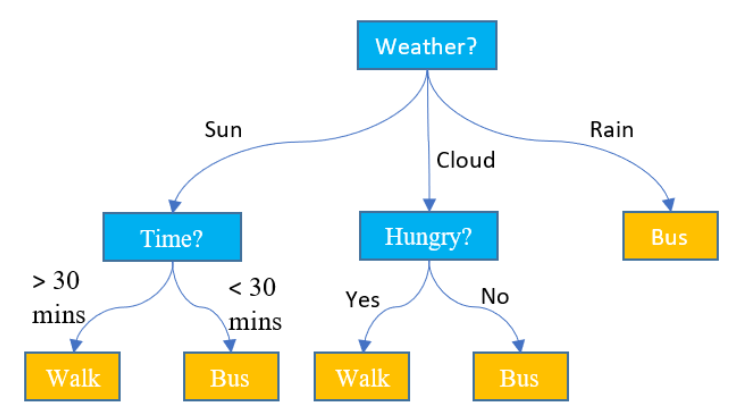
</strong>

我们用Lending Club的例子来介绍如何使用决策数来预测坏账。与前几个章节类似，我们先引进一些工具函数，同时对数据也做一些处理。

In [1]:
import numpy as np
import math

def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

def accuracy(prediction, actual):
    pred_actual_pairs = list(zip(prediction, actual))
    sorted_pred_actual_pairs = sorted(pred_actual_pairs, key = lambda x: x[0])
    pos = [int(len(sorted_pred_actual_pairs)*t) for t in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]]
    cutoffs = [sorted_pred_actual_pairs[t][0] for t in pos]
    cutoffs.insert(0, 0)
    cutoffs.append(1)
    pred_actual_groups = [[(x[0], x[1]) for x in sorted_pred_actual_pairs if x[0]>cutoffs[t] and x[0]<=cutoffs[t+1]] for t in range(10)]
    pred_actual_group_average = [(mean([t[0] for t in group]), mean([t[1] for t in group])) for group in pred_actual_groups]
    acc = 1 - sum([abs(t[0]-t[1]) for t in pred_actual_group_average])/(10*mean([t[1] for t in pred_actual_group_average]))
    return acc, pred_actual_group_average

def mean(v):
    return sum(v) / len(v)

def variance(v):
    n = len(v)
    ave = mean(v)
    deviation = [x-ave for x in v]
    if n == 0:
        return 0
    else:
        return sum([x**2 for x in deviation]) / (n-1)

def std_dev(v):
    return math.sqrt(variance(v))

def scale(v):
    ave = mean(v)
    std = std_dev(v)
    return [(x-ave)/std for x in v]

In [2]:
import csv
with open('/home/nbuser/library/lending_club_train.csv', 'r') as f:
    reader = csv.reader(f)
    lending_club_train = list(reader)
    
loan_amnt = [int(x[0]) for x in lending_club_train]
term = [x[1] for x in lending_club_train]
int_rate = [float(x[2]) for x in lending_club_train]
installment = [float(x[3]) for x in lending_club_train]
grade = [x[4] for x in lending_club_train]
sub_grade = [x[5] for x in lending_club_train]
emp_length = [x[6] for x in lending_club_train]
home_ownership = [x[7] for x in lending_club_train]
annual_income = [float(x[8]) for x in lending_club_train]
verification_status = [x[9] for x in lending_club_train]
purpose = [x[10] for x in lending_club_train]
dti = [-99999 if x[11]=='' else float(x[11]) for x in lending_club_train]
delinq_2yrs = [x[12] for x in lending_club_train]
loan_status = [x[13] for x in lending_club_train]
issue_d = [x[14] for x in lending_club_train]

dep_var = [1 if x in ("Charged Off", "Default") else 0 for x in loan_status]

dti_category = []
for x in dti:
    if x < 10:
        dti_category.append('<10')     
    elif x < 20:
        dti_category.append('10-20')
    elif x < 30:
        dti_category.append('20-30')
    else:
        dti_category.append('>30')

income_category = []
for x in annual_income:
    if x < 50000:
        income_category.append('<$50K')
    elif x < 100000:
        income_category.append('$50-100K')
    elif x < 150000:
        income_category.append('$100-150K')
    else:
        income_category.append('>$200K')
        
loan_amnt_category = []
for x in loan_amnt:
    if x < 5000:
        loan_amnt_category.append('<$5K')
    elif x < 10000:
        loan_amnt_category.append('$5-10K')
    elif x < 15000:
        loan_amnt_category.append('$10-15K')
    elif x < 20000:
        loan_amnt_category.append('$15-20K')
    else:
        loan_amnt_category.append('>$20K')

In [ ]:
import csv
with open('/home/nbuser/library/lending_club_test.csv', 'r') as f:
    reader = csv.reader(f)
    lending_club_test = list(reader)

t_loan_amnt = [int(x[0]) for x in lending_club_test]
t_term = [x[1] for x in lending_club_test]
t_int_rate = [float(x[2]) for x in lending_club_test]
t_installment = [float(x[3]) for x in lending_club_test]
t_grade = [x[4] for x in lending_club_test]
t_sub_grade = [x[5] for x in lending_club_test]
t_emp_length = [x[6] for x in lending_club_test]
t_home_ownership = [x[7] for x in lending_club_test]
t_annual_income = [float(x[8]) for x in lending_club_test]
t_verification_status = [x[9] for x in lending_club_test]
t_purpose = [x[10] for x in lending_club_test]
t_dti = [-99999 if x[11]=='' else float(x[11]) for x in lending_club_test]
t_delinq_2yrs = [x[12] for x in lending_club_test]
t_loan_status = [x[13] for x in lending_club_test]
t_issue_d = [x[14] for x in lending_club_test]

t_dep_var = [1 if x in ("Charged Off", "Default") else 0 for x in t_loan_status]

t_dti_category = []
for x in t_dti:
    if x < 10:
        t_dti_category.append('<10')     
    elif x < 20:
        t_dti_category.append('10-20')
    elif x < 30:
        t_dti_category.append('20-30')
    else:
        t_dti_category.append('>30')

t_income_category = []
for x in t_annual_income:
    if x < 50000:
        t_income_category.append('<$50K')
    elif x < 100000:
        t_income_category.append('$50-100K')
    elif x < 150000:
        t_income_category.append('$100-150K')
    else:
        t_income_category.append('>$200K')
        
t_loan_amnt_category = []
for x in t_loan_amnt:
    if x < 5000:
        t_loan_amnt_category.append('<$5K')
    elif x < 10000:
        t_loan_amnt_category.append('$5-10K')
    elif x < 15000:
        t_loan_amnt_category.append('$10-15K')
    elif x < 20000:
        t_loan_amnt_category.append('$15-20K')
    else:
        t_loan_amnt_category.append('>$20K')

在讲决策树之前，我们先讲一个重要的概念，称为熵。熵原本是一个热力学的概念，用来描述一个系统的无序性。但在机器学习中，它用于描述一个事件的不确定性。如果一个事件的结果非常不确定，那么它的熵必然很大。假设一个事件A有$n$个结果，每个结果$i$的可能性是$p_i$，那么事件A的熵定义为：
$$H(A) = H(p_1,p_2,...p_n) = -\sum_{i=1}^{n}p_i log_2{p_i}$$

上面这个式子当$p_i$全相等时，它的值最大；当某一个$p_i$对于1时，这个式子取最小值0.

那么熵和寻找最优决策树有什么关系呢？决策树的目标就是提高最终预测结果的确定性，也就是在每个叶节点的数据应尽量是由0或者1所组成的。用熵的语言说，就是当数据从一个父节点划分成两个或多个子节点时，熵应该逐渐减小，或者说子节点的确定性应比父节点的确定性来得大。

下面是如何计算在一个样本集上的熵以及当我们细分一个样本集时如何来计算熵。

In [ ]:
import math
from collections import defaultdict, Counter
def entropy(class_probabilities):
    return sum(-p * math.log(p, 2) for p in class_probabilities if p) 

def class_probabilities(labels): 
    total_count = len(labels) 
    return [count / total_count for count in Counter(labels).values()]

def data_entropy(labeled_data): 
    labels = [label for _, label in labeled_data] 
    probabilities = class_probabilities(labels) 
    return entropy(probabilities)

def partition_entropy(subsets):
    total_count = sum(len(subset) for subset in subsets)
    return sum( data_entropy(subset) * len(subset) / total_count for subset in subsets )

def partition_by(inputs, attribute):
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute]
        groups[key].append(input) 
    return groups

def partition_entropy_by(inputs, attribute):
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())


下面一段程序是对一给定的决策树，如何来计算一个输入样本点的预测值。

In [ ]:
def classify(tree, input):
    if isinstance(tree, (float, int)): 
        return tree
    
    attribute, subtree_dict = tree
    subtree_key = input.get(attribute) 
    if subtree_key not in subtree_dict:
        subtree_key = None
    subtree = subtree_dict[subtree_key]
    return classify(subtree, input)

有了上面的准备工作后，我们就可以来写决策树的主干程序了。这儿我们用到一种程序中常见的技巧‘递归’来实现决策树。为了简明扼要，我们假设所有的自变量都是离散变量，也就是每个自变量只取有限个值。我们将实现包含连续变量的决策树作为课后练习。

In [ ]:
from functools import partial
def build_tree(inputs, split_candidates=None):
    if split_candidates is None: 
        split_candidates = inputs[0][0].keys()

    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label == 1]) 
    num_falses = num_inputs - num_trues

    if num_trues == 0: return 0 
    if num_falses == 0: return 1
    if num_inputs <= 5000: return num_trues / num_inputs

    if not split_candidates:
        return num_trues / num_inputs 
        
    best_attribute = min(split_candidates, key=partial(partition_entropy_by, inputs))
    partitions = partition_by(inputs, best_attribute) 
    new_candidates = [a for a in split_candidates if a != best_attribute]
        
    subtrees = { attribute_value : build_tree(subset, new_candidates) for attribute_value, subset in partitions.items() }
    subtrees[None] = num_trues / num_inputs
    return (best_attribute, subtrees)

In [ ]:
def convert_tuple_to_dict(iterator, *names):
    dict = {}
    s = 0
    for name in names:
        dict[name] = iterator[s]
        s = s + 1
    return dict

In [ ]:
predictors = [convert_tuple_to_dict(row, 'grade', 'term', 'emp_length', 'purpose') for row in zip(grade, term, emp_length, purpose)]
data = list(zip(predictors, dep_var))

In [ ]:
t_predictors = [convert_tuple_to_dict(row, 'grade', 'term', 'emp_length', 'purpose') for row in zip(t_grade, t_term, t_emp_length, t_purpose)]
t_data = list(zip(t_predictors, t_dep_var))

In [ ]:
tree = build_tree(data)

In [ ]:
pred = [classify(tree, x[0]) for x in data ]

In [ ]:
gini_normalized(dep_var, pred)

In [ ]:
t_pred = [classify(tree, x[0]) for x in t_data ]

In [ ]:
gini_normalized(t_dep_var, t_pred)

尽管单个决策树模型和其它基本的机器学习方法相比，并不是非常突出，但是当我们把很多个决策树的模型合成起来，模型的效率往往会显著提高。所以决策树是机器学习中一些最有效的模型的基本组成单元。下面就来介绍这些方法中的其中一员，随机森林法。

随机森林是基于决策树的一种模型合成方法。在建立每一个决策树模型前，我们对整个训练样本集提取一个随机的样本，对于所有的自变量也随机地选取一组特征，然后基于这个随机样本建立一个仅包含这组随机特征的决策树。我们可以重复这个过程很多遍，建立很多棵决策树，最后对于任一个输入样本点的预测就是这批决策树的预测的平均值。

下面是随机森林算法的实现。

In [ ]:
def forest_classify(trees, input):
    s = 0
    for tree in trees:
        s = s + classify(tree, input)
    return s / len(trees)

In [ ]:
import random
def random_forest(inputs, split_candidates, row_sampling_rate, column_sampling_rate, size):
    if split_candidates is None: 
        split_candidates = inputs[0][0].keys()
    trees = []
    for _ in range(size):
        inputs_sample = random.sample(inputs, int(len(inputs)*row_sampling_rate))
        candidates_sample = random.sample(split_candidates, int(len(split_candidates)*column_sampling_rate))
        trees.append(build_tree(inputs_sample, candidates_sample))
    return trees

In [ ]:
predictors = [convert_tuple_to_dict(row, 'grade', 'term', 'emp_length', 'purpose','home_ownership','verification_status','dti','income','loan_amnt') for row in zip(grade, term, emp_length, purpose, home_ownership, verification_status, dti_category, income_category, loan_amnt_category)]
data = list(zip(predictors, dep_var))

In [ ]:
t_predictors = [convert_tuple_to_dict(row, 'grade', 'term', 'emp_length', 'purpose','home_ownership','verification_status','dti','income','loan_amnt') for row in zip(t_grade, t_term, t_emp_length, t_purpose, t_home_ownership, t_verification_status, t_dti_category, t_income_category, t_loan_amnt_category)]
t_data = list(zip(t_predictors, t_dep_var))

In [ ]:
trees = random_forest(inputs = data, split_candidates = None, row_sampling_rate = 0.5, column_sampling_rate = 0.5, size = 50)

In [ ]:
pred = [forest_classify(trees, x[0]) for x in data ]

In [ ]:
gini_normalized(dep_var, pred)

In [ ]:
t_pred = [forest_classify(trees, x[0]) for x in t_data ]

In [ ]:
gini_normalized(t_dep_var, t_pred)